In [195]:
from clickhouse_driver import Client
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import binom
import seaborn as sns

client = Client('localhost')

In [196]:
STEP_SIZE = 0.001
EPSILON = 1e-10

In [265]:
def gen_grid(x):
    x_max = np.max(x)
    x_min = np.min(x)
    x_step = (x_max - x_min) * STEP_SIZE
    x_grid = np.arange(x_min, x_max + STEP_SIZE - EPSILON, x_step)
    return x_grid

class DataGen(object):
    @staticmethod
    def normal(num_points, mean=0.0, sd=1.0):
        return DataGen.normal_multimodal(num_points, [mean], [sd])

    @staticmethod
    def normal_multimodal(num_points, means, sds, p=0.3):
        binom_size = len(means) - 1
        choices = np.random.binomial(binom_size, p=p, size=(num_points,1))

        x_c = np.asarray([
            (s * np.random.randn(num_points, 1) + m) * (choices == m_id)
            for m_id, (m, s) in enumerate(zip(means, sds))
        ])
        x = np.sum(x_c, axis=0)

        x_grid = gen_grid(x)

        pdf_c = np.asarray([
            binom.pmf(m_id, n=binom_size, p=p) * norm.pdf(x_grid, loc=m, scale=s)
            for m_id, (m, s) in enumerate(zip(means, sds))
        ])
        pdf = np.sum(pdf_c, axis=0)

        cdf_c = np.asarray([
            binom.pmf(m_id, n=binom_size, p=p) * norm.cdf(x_grid, loc=m, scale=s)
            for m_id, (m, s) in enumerate(zip(means, sds))
        ])
        cdf = np.sum(cdf_c, axis=0)    
        return (
            x, 
            pd.DataFrame({"x": x_grid, "pdf": pdf}),
            pd.DataFrame({"x": x_grid, "cdf": cdf})
        )

In [309]:
methods = [
    "quantiles",
    "quantilesExact",
    "quantilesTDigest",
    "quantilesMomentSketch",
]

def insert(x):
    client.execute("DROP TABLE IF EXISTS data")
    client.execute("CREATE TABLE data(x Float64) ENGINE = Memory")
    client.process_insert_query("INSERT INTO data VALUES", x)

def query(q):
    q_str = ",".join(["{:.4f}".format(qq) for qq in q])
    r = np.asarray([
        client.execute("SELECT {}({})(x) FROM data".format(m, q_str))
        for m in methods
    ])

    return pd.DataFrame(
        r.reshape((len(methods), len(q))), 
        index=methods
    )

def plot_cdf(xs, q, cdf_true=None):
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(111)

    if cdf_true is not None:
        plt.plot(cdf_true.x, cdf_true.cdf)

    for _, x in xs.iterrows():
        plt.plot(x, q)

    ax.set_title("CDF function")
    ax.set_xlabel("x")
    ax.set_ylabel("CDF")
    legend = xs.index.tolist()

    ax.legend(
        legend 
        if cdf_true is None else 
        ["true"] + legend, 
        loc='upper right'
    )
    return ax

def calc_pdf(x, q):
    return np.asarray([
        (q[i + 1] - q[i - 1]) / (x[i + 1] - x[i - 1]) for i in range(1, len(q) - 1)
    ])

def plot_pdf(xs, q, pdf_true=None):
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(111)

    if pdf_true is not None:
        plt.plot(pdf_true.x, pdf_true.pdf)

    for _, x in xs.iterrows():
        pdf = calc_pdf(x, q)
        plt.plot(x[1:-1], pdf)
    
    ax.set_title("PDF function")
    ax.set_xlabel("x")
    ax.set_ylabel("PDF")
    
    legend = xs.index.tolist()

    ax.legend(
        legend 
        if pdf_true is None else 
        ["true"] + legend, 
        loc='upper right'
    )
    return ax
    
def select_rows(x, *idx):
    return pd.DataFrame([x.loc[id] for id in idx])

In [365]:
num_points = 100000

# gen = lambda: DataGen.normal(num_points, mean=1.0, sd=1.0)
# gen = lambda: DataGen.normal_multimodal(num_points, means=[-0.5, 0.5, 0.0], sds=[0.1, 0.2, 0.4])
# gen = lambda: DataGen.normal_multimodal(num_points, means=[-0.5, 0.5, 0.0], sds=[0.1, 0.2, 0.4])
gen = lambda: DataGen.normal(num_points, mean=10.0, sd=5.0)

x, x_pdf, x_cdf = gen()

quantiles = np.arange(0.0, 1.0 + STEP_SIZE, STEP_SIZE)

insert(x)
xs = query(quantiles)

Error on socket shutdown: [Errno 57] Socket is not connected


EOFError: Unexpected EOF while reading bytes

In [ ]:
plot_pdf(xs, quantiles);

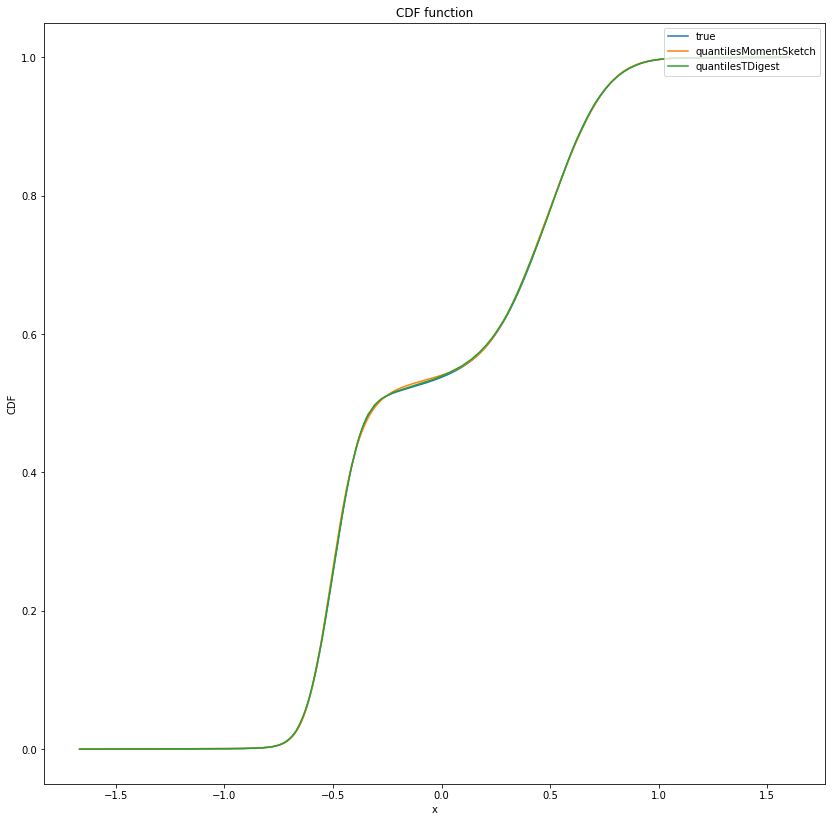

In [364]:
plot_cdf(select_rows(xs, "quantilesMomentSketch", "quantilesTDigest"), quantiles, x_cdf);